In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json
import seaborn
from os.path import join
%matplotlib inline

In [2]:
from pbcore.io import CmpH5Reader
import h5py
from PRmm.io import TrcH5Reader, DmeDumpReader
from PRmm.extras.ellipse import *

t2bAlns = CmpH5Reader("/home/UNIXHOME/dalexander/Projects/SequelFrenzy/All4Mers-3150005-0026-bakeoff/T2B-mainline-dmeDump/aligned_reads.cmp.h5")
pocAlns = CmpH5Reader("/home/UNIXHOME/dalexander/Projects/SequelFrenzy/All4Mers-3150005-0026-bakeoff/POC/aligned_reads.cmp.h5")

In [3]:
dmeDump = DmeDumpReader("/home/UNIXHOME/dalexander/Projects/SequelFrenzy/All4Mers-3150005-0026-bakeoff/T2B-mainline-dmeDump/dme-dump.h5")
traces = TrcH5Reader("/pbi/collections/315/3150005/r54004_20151201_015856/1_A01/m54004_151201_015904.trc.h5")

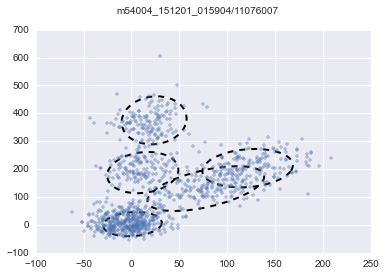

In [4]:
#hn = 12910995 # a bad ZMW
hn = 11076007 # a good ZMW

s = dmeDump.hole(hn)


block=116
bl = s.baseline[block]
#blRev = np.array([bl[1], bl[0]])

sf, ef = s.startFrame[block], s.endFrame[block] 
rawTrace = traces[hn] [:,sf:ef]
trace = rawTrace - bl[:,np.newaxis]
means = s.mean[block]

#plt.plot(trace[0,:], trace[1,:], '.', alpha=0.4)
plt.plot(trace[0,:], trace[1,:], '.', alpha=0.4)

plt.suptitle(traces.movieName + "/" + str(hn))

from PRmm.extras.ellipse import *
es = [ covarianceEllipse3(m, c3, 3.0)
       for (m, c3) in zip(s.mean[block],
                          s.covariance[block]) ]
ax = plt.gca()
for e in es:
    ax.add_artist(e)

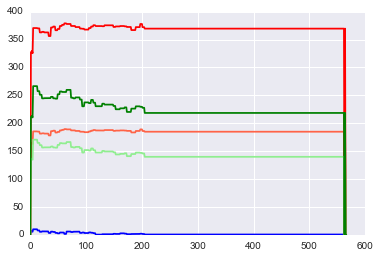

In [19]:
#hn = 12910995 # a bad ZMW
hn = 11076007 # a good ZMW

s = dmeDump.hole(hn)

meansOverTime = s.mean
covarsOverTime = s.covariance

def det2(M3): 
    return M3[0]*M3[1]-M3[2]*M3[2]

#print covarsOverTime.shape
detsOverTime = np.apply_along_axis(det2, 2, covarsOverTime)

meanAmplitudesOverTime = np.apply_along_axis(np.linalg.norm, 2, meansOverTime)

ax = plt.gca()
COLOR_CYCLE_5COMPONENTS = ['b', 'tomato', 'red', 'lightgreen', 'green']
ax.set_color_cycle(COLOR_CYCLE_5COMPONENTS)


#plt.plot(detsOverTime)
plt.plot(meanAmplitudesOverTime)



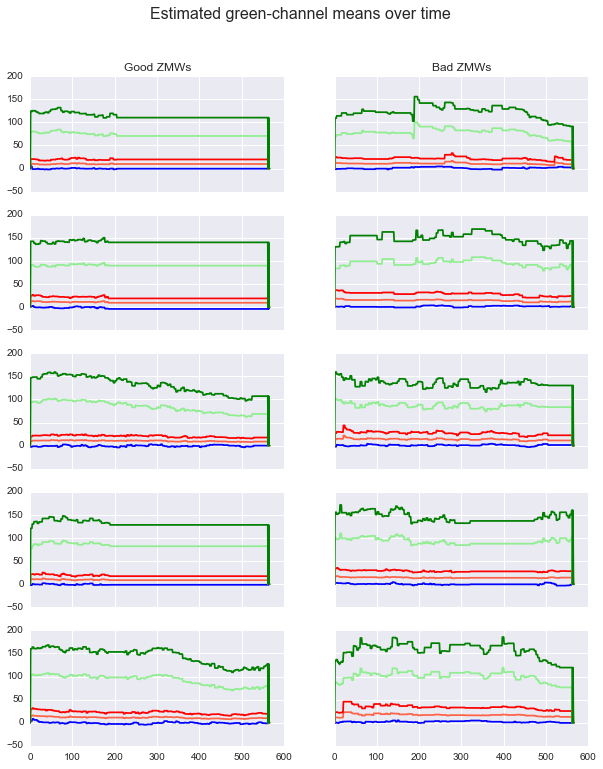

In [20]:
goodHns = [11076007, 13304707, 29163702, 30147440, 30802094] # Similar good accuracy
badHns  = [12910995, 28901550, 30802587, 31196022, 31850905] # T2Bacc <= POCacc - 15

fig, ax = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(10, 12))
for i, hn in enumerate(goodHns):
    s = dmeDump.hole(hn)
    meansOverTime = s.mean
    ax[i, 0].set_color_cycle(COLOR_CYCLE_5COMPONENTS)
    ax[i, 0].plot(meansOverTime[...,0])
    
for i, hn in enumerate(badHns):
    s = dmeDump.hole(hn)
    meansOverTime = s.mean
    ax[i, 1].set_color_cycle(COLOR_CYCLE_5COMPONENTS)
    ax[i, 1].plot(meansOverTime[...,0])
    

ax[0, 0].set_title("Good ZMWs")
ax[0, 1].set_title("Bad ZMWs")
fig.suptitle("Estimated green-channel means over time", fontsize=16)



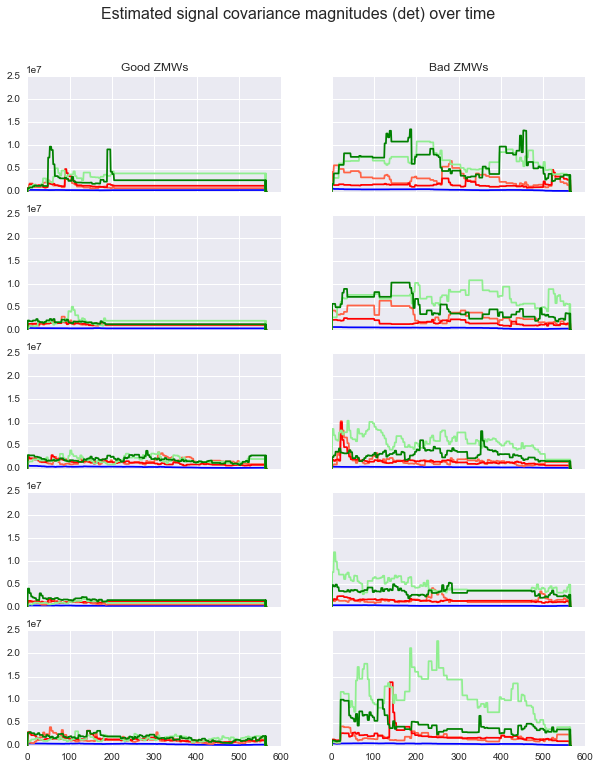

In [23]:
fig, ax = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(10, 12))
for i, hn in enumerate(goodHns):
    s = dmeDump.hole(hn)
    covarsOverTime = s.covariance
    detOverTime = np.apply_along_axis(det2, 2, covarsOverTime)
    ax[i, 0].set_color_cycle(COLOR_CYCLE_5COMPONENTS)
    ax[i, 0].plot(detOverTime)
    
for i, hn in enumerate(badHns):
    s = dmeDump.hole(hn)
    covarsOverTime = s.covariance
    detOverTime = np.apply_along_axis(det2, 2, covarsOverTime)
    ax[i, 1].set_color_cycle(COLOR_CYCLE_5COMPONENTS)    
    ax[i, 1].plot(detOverTime)
    
ax[0, 0].set_title("Good ZMWs")
ax[0, 1].set_title("Bad ZMWs")
fig.suptitle("Estimated signal covariance magnitudes (det) over time", fontsize=16)
    

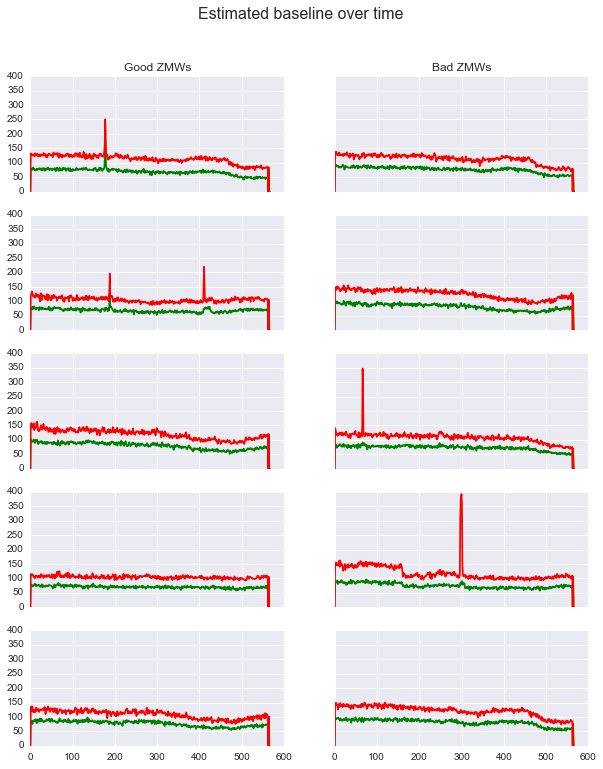

In [8]:
# check baselines, just to be safe
fig, ax = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(10, 12))
for i, hn in enumerate(goodHns):
    s = dmeDump.hole(hn)
    ax[i, 0].set_color_cycle(['g', 'r'])
    ax[i, 0].plot(s.baseline)
    
for i, hn in enumerate(badHns):
    s = dmeDump.hole(hn)
    ax[i, 1].set_color_cycle(['g', 'r'])    
    ax[i, 1].plot(s.baseline)
    
ax[0, 0].set_title("Good ZMWs")
ax[0, 1].set_title("Bad ZMWs")
fig.suptitle("Estimated baseline over time", fontsize=16)

In [24]:
from PRmm.model import ReadersFixture
fx = ReadersFixture.fromIniFile(
    "/home/UNIXHOME/dalexander/Projects/SequelFrenzy/All4Mers-3150005-0026-bakeoff/fixture.ini", 
    "T2B")

def getRepresentativeBlock(hn):
    # Grab a DME dump block "mid-alignment"
    z = fx[hn]
    alnRegionFrames = z.regions.alignment
    mf = (alnRegionFrames.startFrame + alnRegionFrames.endFrame)/2.0
    midAlnBlock = np.argmin(abs(dmeDump.startFrame - mf))
    return dmeDump.holeAndBlock(hn, midAlnBlock)    

data = []

for hn in fx.holeNumbersWithAlignments[:2000]:
    block = getRepresentativeBlock(hn)
    covars = list(np.apply_along_axis(det2, 1, block.covariance))
    acc = fx[hn].alignment.identity
    row = [hn, acc] + covars
    data.append(row)
    
df = pd.DataFrame(data=data,
                  columns=["HoleNumber", "Accuracy", "CovBL", "CovA", "CovC", "CovG", "CovT"])


In [57]:
df.to_csv("/tmp/foo.csv", index=False)


In [ ]:
z.regions.alignment.startFrame

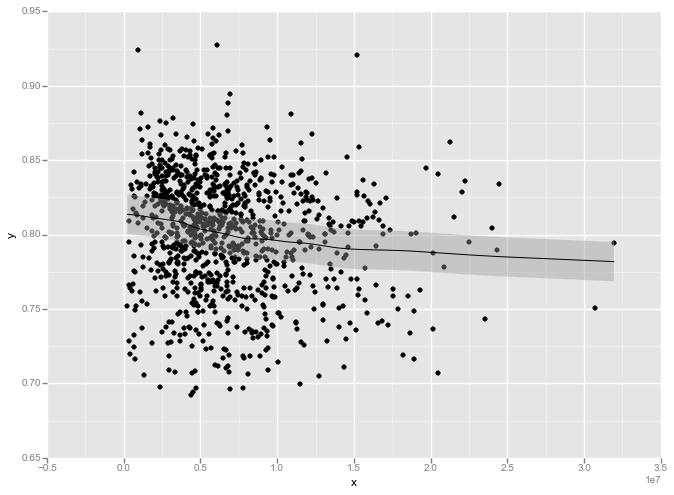

<ggplot: (291519789)>

In [52]:
import ggplot as gg

#gg.qplot(df.CovA, df.Accuracy) + gg.geom_smooth()
gg.qplot(df.CovG, df.Accuracy) + gg.geom_smooth()


In [56]:
?df.to_csv

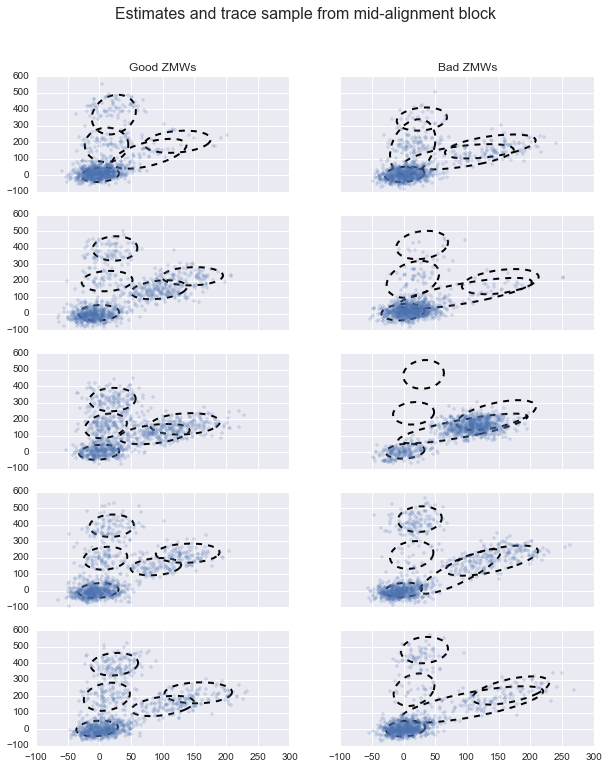

In [36]:
from PRmm.extras.ellipse import *
fig, ax = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(10, 12))

for (col, hns) in enumerate([goodHns, badHns]):
    for (i, hn) in enumerate(hns):
        s = getRepresentativeBlock(hn)
        block = s.block
        sf, ef = s.startFrame, s.endFrame
        rawTrace = traces[hn] [:,sf:ef]
        trace = rawTrace - bl[:,np.newaxis]
        ca = ax[i, col]
        ca.plot(trace[0,:], trace[1,:], '.', alpha=0.2)
        es = [ covarianceEllipse3(m, c3, 3.0)
               for (m, c3) in zip(s.mean, s.covariance) ]
        for e in es:
            ca.add_artist(e)

ax[0, 0].set_title("Good ZMWs")
ax[0, 1].set_title("Bad ZMWs")    

fig.suptitle("Estimates and trace sample from mid-alignment block", fontsize=16)


In [30]:
block

104

In [27]:
block.block

104